## Business Understanding
Ever since the roll out of bike hire schemes for on the fly bike usage, companies have tried to forecast how many bicycles they’ll need in set locations at a given time in order to meet demand, and it hasn’t been an easy feat. In an age where alternative transport methods are being ever more widely explored, this issue has become more prominent and of bigger interest. What helps us understand bike sharing demand and can we forecast it?

We have three key questions to help us understand bike sharing problem. 
Let's assess some key hypotheses about what could impact bike sharing and help us answer these.

1. Does weather impact bike hire? 
<br> &emsp; a. seasonality
<br> &emsp; b. temperature
<br> &emsp; c. weather conditions
<br> &emsp; d. what about a mix of weather conditions, e.g. if its sunny but cold could be nice for cycling...
<br> &emsp; e. interaction of variables? summer might be great vs winter, but is a sunny winter day a stronger predictor, or a wet summer day, vs the variable alone?
<br>

2. Is demand the same regardless of what day of the week it is? 
<br> &emsp; a. Is every weekday the same? 
<br> &emsp; b. Weekend vs weekdays? 
<br> &emsp; c. Mondays more energy? Too tired by end of week? 
<br> &emsp; d. Is bike sharing demand consistent?
3. How well can we predict bike share demand? 
Stepwise regression, RandomForest regressor, XGBoost 


In [29]:
# Install libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import sklearn.metrics as metrics
from time import time
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from xgboost import XGBRegressor
#from sklearn.cluster import KMeans
#from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime

In [30]:
# import data
# !pip install opendatasets - could not install package due to SSO issues
# import opendatasets as od
train_data = pd.read_csv("/Users/karina.gorasia/Downloads/bike-sharing-demand/train.csv")
test_data = pd.read_csv("/Users/karina.gorasia/Downloads/bike-sharing-demand/test.csv")

# datetime - hourly date + timestamp  
# season -  1 = winter, 2 = spring, 3 = summer, 4 = fall 
# holiday - whether the day is considered a holiday
# workingday - whether the day is neither a weekend nor holiday
# weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
# temp - temperature in Celsius
# atemp - "feels like" temperature in Celsius
# humidity - relative humidity
# windspeed - wind speed
# casual - number of non-registered user rentals initiated
# registered - number of registered user rentals initiated
# count - number of total rentals

## Data Understanding and Exploratory Data Analysis
Check dtypes, assess nulls, understand features

In [31]:
#snapshot of training data
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [32]:
#snapshot of test data
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [33]:
# change column datatypes to more appropriate type
train_data = train_data.astype({'datetime': 'datetime64', 'season': 'category', 'holiday': 'bool', 'workingday':'bool'})
train_data.dtypes

datetime      datetime64[ns]
season              category
holiday                 bool
workingday              bool
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [34]:
#check for nulls
train_data.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [35]:
# get data descriptions/stats
train_data.describe()

,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [36]:
test_data.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [37]:
test_data = test_data.astype({'datetime': 'datetime64', 'season': 'category', 'holiday': 'category', 'workingday':'category'})
test_data.dtypes

datetime      datetime64[ns]
season              category
holiday             category
workingday          category
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object

In [38]:
test_data.describe()

,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,1.436778,20.620607,24.012865,64.125212,12.631157
std,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.820000,0.000000,16.000000,0.000000
25%,1.000000,13.940000,16.665000,49.000000,7.001500
50%,1.000000,21.320000,25.000000,65.000000,11.001400
75%,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,40.180000,50.000000,100.000000,55.998600


In [39]:
# combine data if needed at later stage
combined_data = train_data.drop(["casual","registered","count"], axis=1).append(test_data)
combined_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [40]:
combined_data.describe()

,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540
std,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795
min,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500
50%,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000
75%,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900
max,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900


<AxesSubplot:>

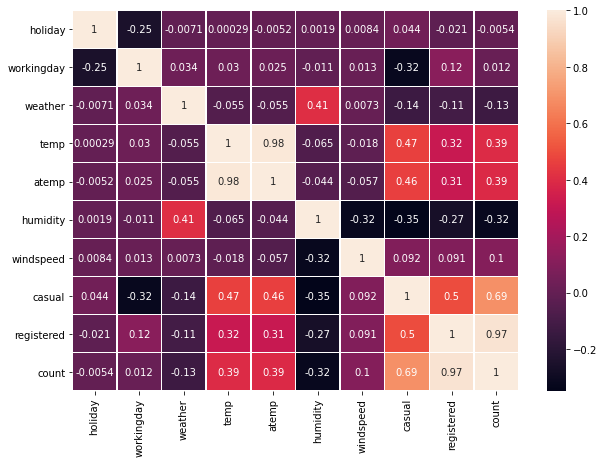

In [41]:
# corr matrix
corrMatrix = train_data.corr()
#sns.heatmap(corrMatrix, annot=True)
#plt.show()
fig, ax = plt.subplots(figsize=(10,7))         # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

We can see from this above chart that some features demonstrate correlation with count of bikes hired, for example humidity has a negative correlation, and temperature a fair positive, however none of these have a strong/high correlation(registered and casual do not count as they are multicollinear and tied with the target). The EDA analysis may help prove some underlying patterns better.

### Looking at features more explicitly

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

<AxesSubplot:xlabel='windspeed', ylabel='Density'>

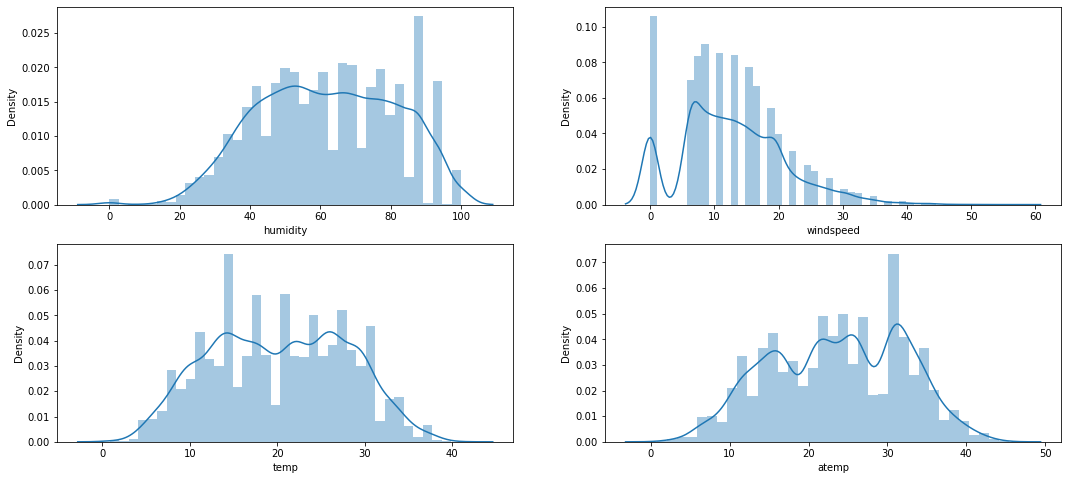

In [42]:
# distplot in continuous variable
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(18,8)

sns.distplot(train_data['temp'],ax=axes[1][0])
sns.distplot(train_data['atemp'],ax=axes[1][1])
sns.distplot(train_data['humidity'],ax=axes[0][0])
sns.distplot(train_data['windspeed'],ax=axes[0][1])
#sns.distplot(train_data['count'],ax=axes[1][1])

Note that the count target variable is heavily left skewed, suggesting some kind of transformation to make the distribution more normalised could aid model performance. Temperature has an almost bimodel distribution, something to explore when analysing how temperatures impact bike sharing demand, but also interesting this pattern does not follow for atemp (feels like temp) which one would believe to be the case. It will be interesting to see how these compare when analysing more closely. The distribution for humidity is unsurprising, and for windspeed, we seem to see a peak at 0, which is slightly disproportionate, suggesting either 0's have been imputed, the windspeed was not available for a number of cases, or less likely, that windspeed is frequently that low? Something to bear in mind when interpreting results.

<AxesSubplot:xlabel='season'>

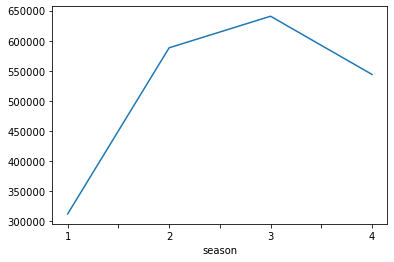

In [43]:
# How many hires do we get depending on the season? 
# Summer has peak bike hire, with spring the second most and winter the least - something we would expect.
# train_data.groupby("season")['count'].sum().plot(kind="bar") #do we have the same amount of days for this data? any gaps in data?
train_data.groupby("season")['count'].sum().plot.line(rot=0)

<AxesSubplot:xlabel='temp_buckets'>

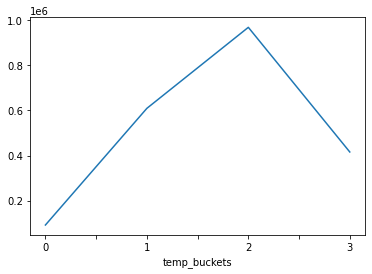

In [44]:
# we know from the data stats, there are no sub zero temperatures in this dataset
temp_conditions = [
    (train_data['temp'] >= 0) & (train_data['temp'] < 10),
    (train_data['temp'] >= 10) & (train_data['temp'] < 20),
    (train_data['temp'] >= 20) & (train_data['temp'] < 30),
    (train_data['temp'] > 30)
]
temp_choices = [0,1,2,3] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
train_data['temp_buckets'] = np.select(temp_conditions, temp_choices, default='999')

train_data.groupby("temp_buckets")['count'].sum().plot.line(rot=0)

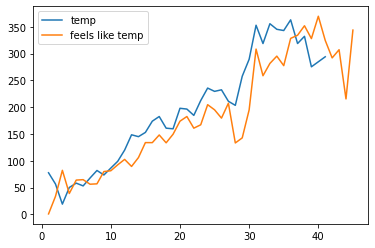

In [45]:
# there is a clear correlation between milder temperatures and bike hire
# bike hire increases the warmer the weather, though weirdly there is a dip at the 27c mark, meaning the trend isnt entirely smooth.
# interestingly, the warmer it feels, the more bike hire there is, even if the real temp isnt that high.
# this suggests actual temprature could help estimate bike demand, particularly if it is expected to feel warmer than it actually is.
a = train_data[['temp','count']].round(0).groupby(['temp'])['count'].mean().reset_index()
b = train_data[['atemp','count']].round(0).groupby(['atemp'])['count'].mean().reset_index()
plt.plot(a['temp'], a['count'], label = "temp")
plt.plot(b['atemp'], b['count'], label = "feels like temp")
plt.legend()
plt.show()

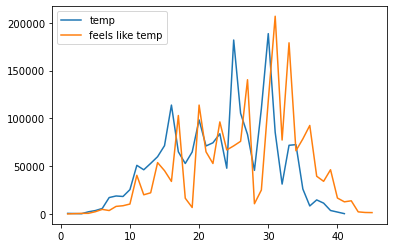

In [46]:
#what is interesting is that looking at total bikes hired by temp, there is quite some volatility, suggested other factors are indeed coming into play and warm temps alone are not a strong enough indicator for bike sharing demand
a = train_data[['temp','count']].round(0).groupby(['temp'])['count'].sum().reset_index()
b = train_data[['atemp','count']].round(0).groupby(['atemp'])['count'].sum().reset_index()
plt.plot(a['temp'], a['count'], label = "temp")
plt.plot(b['atemp'], b['count'], label = "feels like temp")
plt.legend()
plt.show()

<AxesSubplot:xlabel='weather'>

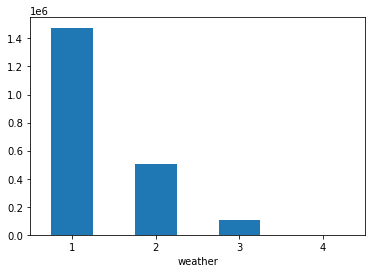

In [47]:
# How many hires do we get depending on the weather? 
# a few clouds doesn't seem to deter people from hiring bikes, nor does a little mist, but unsurprisingly, throw in rain and theres a serious decline
train_data.groupby("weather")['count'].sum().plot.bar(rot=0)

<AxesSubplot:xlabel='humidity'>

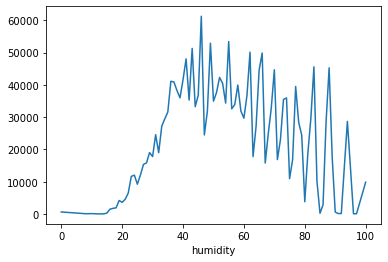

In [48]:
# How does humidity impact bike hire? there are some peaks in demand when humidity is higher
train_data.groupby("humidity")['count'].sum().plot.line(rot=0)

<AxesSubplot:xlabel='humidity'>

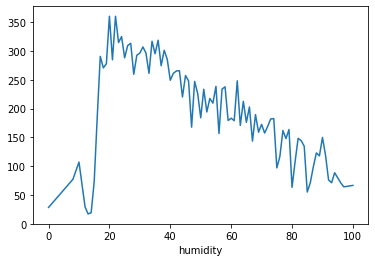

In [49]:
# the peaks arent representative of average behaviour, generally the more humid, the lower demand, and a few occurances drove the total count to be high
train_data.groupby("humidity")['count'].mean().plot.line(rot=0)

<AxesSubplot:xlabel='humidity'>

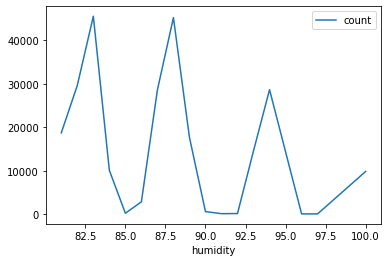

In [50]:
# what causes those spikes in higher demand when humidity is high?
train_data[(train_data['humidity'] > 80)][['humidity','count']].groupby('humidity').sum().plot.line(rot=0)

<AxesSubplot:xlabel='humidity', ylabel='count'>

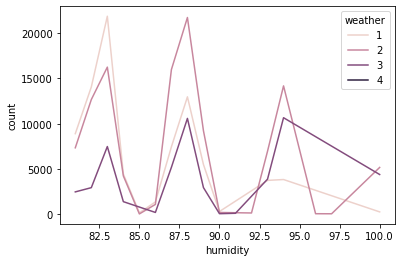

In [51]:
# is it weather? No - we see no distinct weather type which drives this
humiditybyweather = train_data[(train_data['humidity'] > 80)][['humidity','weather','count']].groupby(['weather','humidity']).sum().reset_index()
#humiditybyweather.head()
sns.lineplot(data=humiditybyweather, x='humidity', y='count', hue='weather')

<AxesSubplot:xlabel='humidity', ylabel='count'>

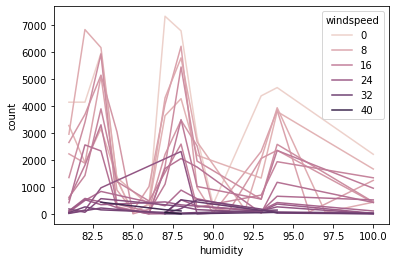

In [52]:
# nor does windspeed directly cause higher demand spikes with high humidity
humiditybywindspeed = train_data[(train_data['humidity'] > 80)][['humidity','windspeed','count']].round(0).groupby(['windspeed','humidity']).sum().reset_index()
#humiditybywindspeed.head()
sns.lineplot(data=humiditybywindspeed, x='humidity', y='count', hue='windspeed')

<AxesSubplot:xlabel='temp_buckets', ylabel='count'>

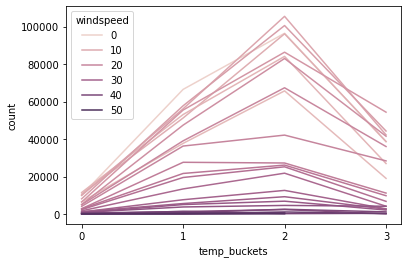

In [53]:
# What about if it's hot but there's a breeze?
tempbucketbywindspeed = train_data[['temp_buckets','windspeed','count']].groupby(['temp_buckets','windspeed']).sum().reset_index()
#tempbucketbywindspeed.head()
sns.lineplot(data=tempbucketbywindspeed, x='temp_buckets', y='count', hue='windspeed')
# the trend of higher demand in warmer temperatures is obvious again here, however we see some difference in particular for buckets 1-3 where lower wind speeds show increased demand, showign potential for a feature to be built, or some intreaction of variables

<AxesSubplot:xlabel='temp', ylabel='count'>

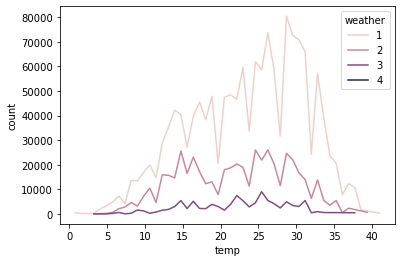

In [54]:
# What about if it's a clear but cool day? or if it's warm but unsettled? weather + temp
weatherbytemptot = train_data[['temp','weather','count']].groupby(['weather','temp']).sum().reset_index()
#weatherbytemptot.head()
sns.lineplot(data=weatherbytemptot, x='temp', y='count', hue='weather')
# of course as temps rise, the weather is expected to be clearer, but we also see a greater tolerance for cooler temps for clear/settled conditions
# we can see this as bike demand is still relatively high  for weather type 2 in 10-20 degrees, and even exists in lower temps.
# potential to create a feature for weather = 1|2 and temp < 20 (cold but dry), or an interaction variable.

<AxesSubplot:xlabel='tempweather_colddry'>

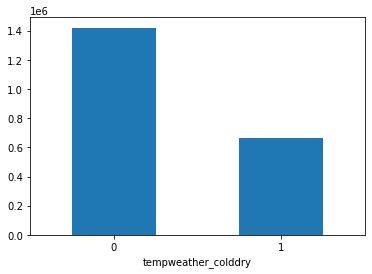

In [55]:
# create feature for settled but cold weather
# note this method has been used a few times in the script but a function is not being created as the conditions, choices and figures vary so greatly there would be many arguments needed and creating the function would be more convoluted then repeating this short code thrice
tempweather_conditions = [
    (train_data['weather'] == 1) & (train_data['temp'] < 20),
    (train_data['weather'] == 2) & (train_data['temp'] < 20)
]
tempweather_choices = [1,1] # 1 = dry but cold, 0 = otherwise
train_data['tempweather_colddry'] = np.select(tempweather_conditions, tempweather_choices, default='0')

train_data.groupby("tempweather_colddry")['count'].sum().plot.bar(rot=0)

<AxesSubplot:xlabel='temp', ylabel='count'>

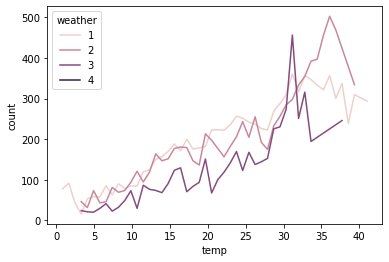

In [56]:
# when looking at average, we see that the hotter it gets, the more cloud cover is actually preferred
weatherbytempavg = train_data[['temp','weather','count']].groupby(['weather','temp']).mean().reset_index()
#weatherbytempavg.head()
sns.lineplot(data=weatherbytempavg, x='temp', y='count', hue='weather')
# potential to create a feature for weather = 2|4 and temp > 30 (hot but cloud cover), or an interaction variable.

<AxesSubplot:xlabel='tempweather_hotcloudy'>

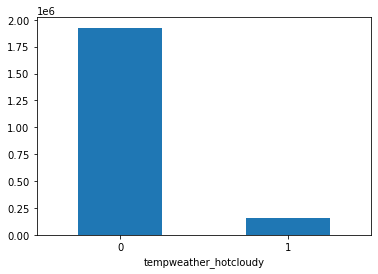

In [57]:
# create feature for hot but covered weather
tempweather_conditions2 = [
    (train_data['weather'] == 2) & (train_data['temp'] > 30),
    (train_data['weather'] == 3) & (train_data['temp'] < 30)
]
tempweather_choices2 = [1,1] # 1 = dry but cold, 0 = otherwise
train_data['tempweather_hotcloudy'] = np.select(tempweather_conditions2, tempweather_choices2, default='0')

train_data.groupby("tempweather_hotcloudy")['count'].sum().plot.bar(rot=0)

<AxesSubplot:xlabel='windspeed', ylabel='count'>

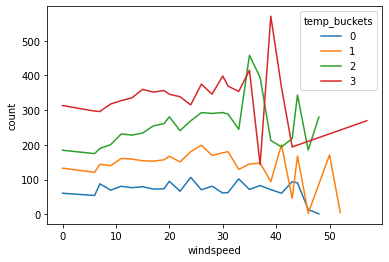

In [58]:
# We've established warm weather is desirable if there's some cover. Does a nice breeze drive demand in warmer temps too?
windspeedbytemptot = train_data[['windspeed','temp_buckets','count']].groupby(['windspeed','temp_buckets']).mean().reset_index()
#windspeedbytemptot.head()
sns.lineplot(data=windspeedbytemptot, x='windspeed', y='count', hue='temp_buckets')
# of course as temps rise, there is certrainly a trend in warmer weather to hire bikes. We see this steep rise primarly in temp bucket 2 and 3, slightly in 1 and not at all in 0, as we would expect. Can't imagine renting a bike in cold and windy weather!
# potential to create a feature for weather = 1|2 and temp < 20 (cold but dry), or an interaction variable.

<AxesSubplot:xlabel='tempweather_warmwindy'>

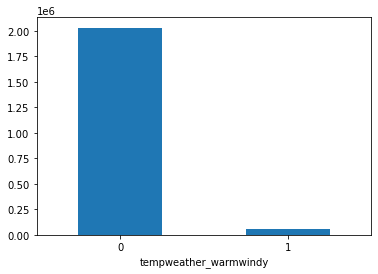

In [59]:
# create feature for hot and windy weather
tempweather_conditions3 = [
    (train_data['windspeed'] > 30) & (train_data['temp'] >= 20) # 20 is as per temp bucket 2,3
]
tempweather_choices3 = [1] # 1 = dry but cold, 0 = otherwise
train_data['tempweather_warmwindy'] = np.select(tempweather_conditions3, tempweather_choices3, default='0')

train_data.groupby("tempweather_warmwindy")['count'].sum().plot.bar(rot=0)
#the barchart is unsurprising given most records have lower temps and lower windspeeds.

In [60]:
# Let's tidy up time and create some features before assessing 
train_data['hour'] = train_data['datetime'].dt.hour
train_data['day'] = train_data["datetime"].dt.day
train_data['dayofweek'] = train_data['datetime'].dt.dayofweek
train_data['month'] = train_data['datetime'].dt.month

<AxesSubplot:xlabel='hour'>

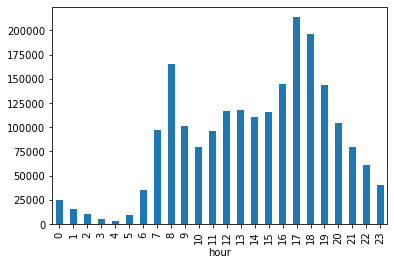

In [61]:
# Does time of day impact hires? Looking generally at all week first, we see some peaks at typical commuting hours
train_data.groupby("hour")['count'].sum().plot(kind="bar")

<BarContainer object of 24 artists>

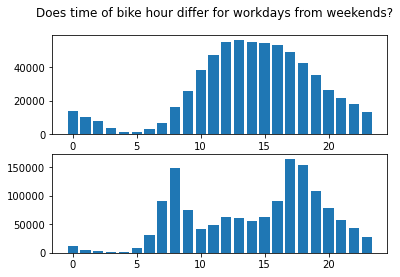

In [62]:
# Does time of bike hour differ for workdays from weekends? yes - we see those peaks for demand more prominently on weekdays, whereas demand at the weekend has a more normal distribution
weekend_bikecounts = train_data[(train_data['workingday'] == 0)].groupby("hour")['count'].sum().reset_index()
workday_bikecounts = train_data[(train_data['workingday'] == 1)].groupby("hour")['count'].sum().reset_index()

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Does time of bike hour differ for workdays from weekends?')
ax1.bar(weekend_bikecounts["hour"], weekend_bikecounts["count"])
ax2.bar(workday_bikecounts["hour"], workday_bikecounts["count"])

<AxesSubplot:xlabel='hour_peak_commute'>

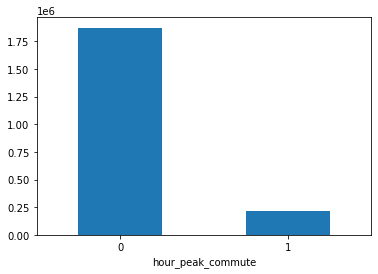

In [63]:
# Let's create a feature for peak commuting hours to cover the two peaks we see
peaktime_conditions = [
    ((train_data['hour'] >= 7) & (train_data['temp'] < 10) & (train_data['workingday'] == 1)) |
    ((train_data['temp'] >= 17) & (train_data['temp'] < 20) & (train_data['workingday'] == 1))
]
peaktime_choices = [1] # 0 = peak commuting time, 1 = off peak
train_data['hour_peak_commute'] = np.select(peaktime_conditions, peaktime_choices, default=0)

train_data.groupby("hour_peak_commute")['count'].sum().plot.bar(rot=0)

In [64]:
train_data['hour_peak_commute'].value_counts()

0    9519
1    1367
Name: hour_peak_commute, dtype: int64

<AxesSubplot:xlabel='dayofweek'>

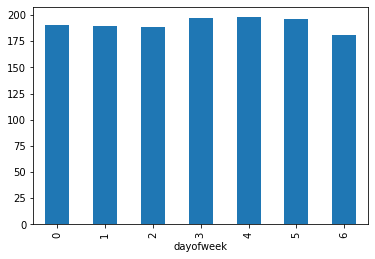

In [65]:
# Are more bikes hired on particular days of the week? No clear difference found.
train_data.groupby("dayofweek")['count'].mean().plot(kind="bar")

<AxesSubplot:xlabel='month'>

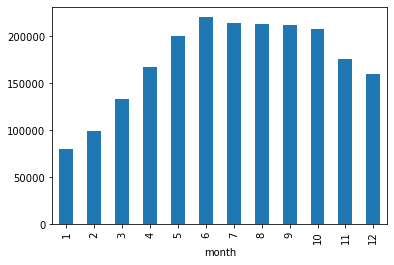

In [66]:
# Are more bikes hired on particular months of the year? as we would expect, winter/cooler months experience less demand
train_data.groupby("month")['count'].sum().plot(kind="bar")

<AxesSubplot:>

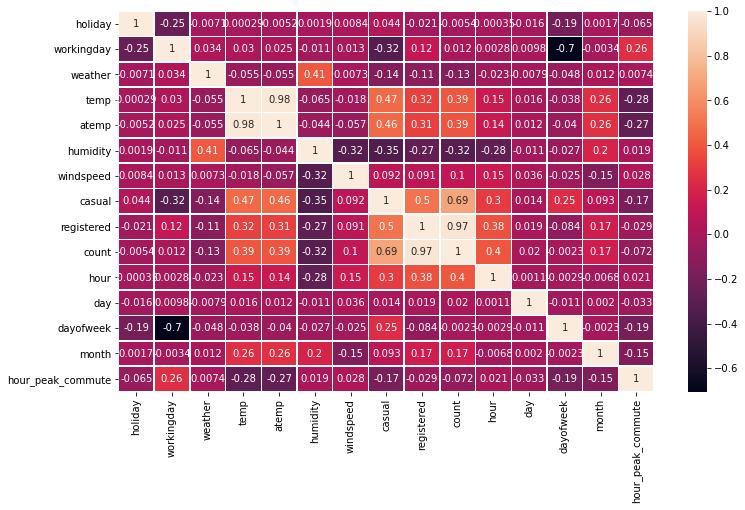

In [67]:
# corr matrix given additional features created in EDA - binary features will not appear. 
# temperature still appears prominent in correlation to the target, but clearly adding in more time features also proves useful with hour having a correlation of 0.4. 
corrMatrix = train_data.corr()
fig, ax = plt.subplots(figsize=(12,7)) # Sample figsize in inches
sns.heatmap(corrMatrix, annot=True, linewidths=.5, ax=ax)

In [68]:
# in order of most correlated with count
pd.DataFrame(train_data.corr().round(4).unstack().sort_values(ascending=False)['count'],columns=['Correlation to the target'])

,Correlation to the target
count,1.0000
registered,0.9709
casual,0.6904
hour,0.4006
temp,0.3945
atemp,0.3898
month,0.1669
windspeed,0.1014
day,0.0198
workingday,0.0116


In [69]:
#built_features = train_data.columns[train_data.dtypes=='object']
built_features = ['temp_buckets','tempweather_colddry','tempweather_hotcloudy','tempweather_warmwindy','hour_peak_commute']
built_features = list(built_features)
built_features

['temp_buckets',
 'tempweather_colddry',
 'tempweather_hotcloudy',
 'tempweather_warmwindy',
 'hour_peak_commute']

<AxesSubplot:xlabel='hour_peak_commute', ylabel='count'>

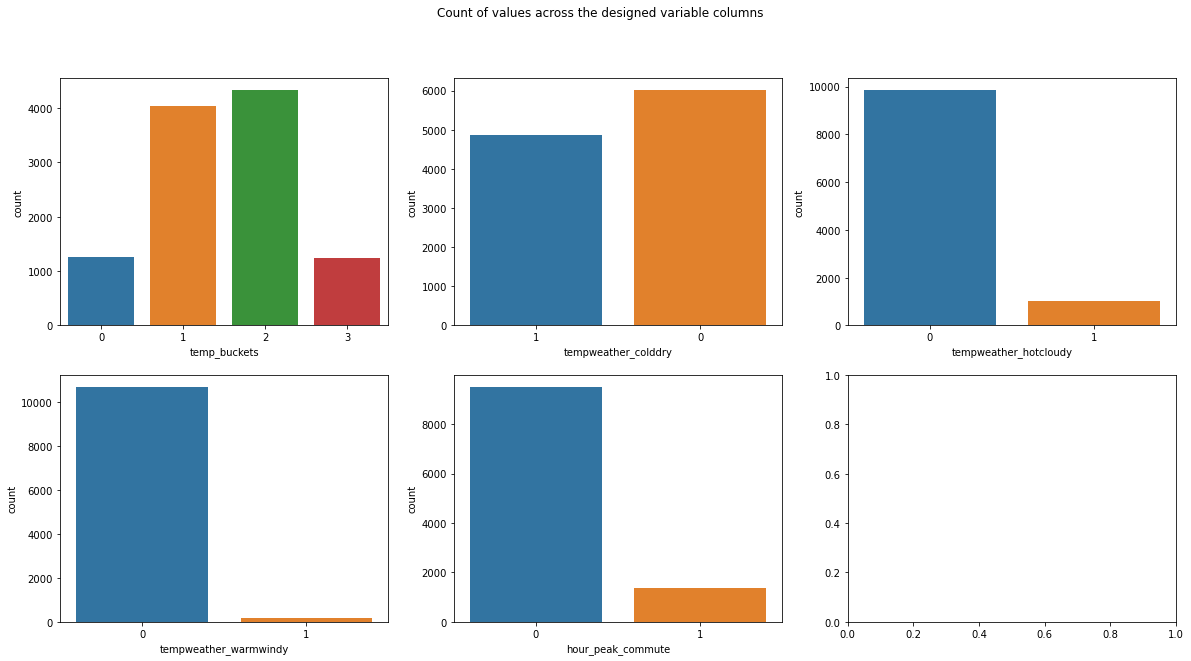

In [70]:
# review featured variables
fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharey=False)
fig.suptitle('Count of values across the designed variable columns') # if these are similar, there is no real differentiator for the model

sns.countplot(x=built_features[0], data=train_data, ax=axes[0,0])
sns.countplot(x=built_features[1], data=train_data, ax=axes[0,1])
sns.countplot(x=built_features[2], data=train_data, ax=axes[0,2])
sns.countplot(x=built_features[3], data=train_data, ax=axes[1,0])
sns.countplot(x=built_features[4], data=train_data, ax=axes[1,1])

## Prepare Data 

Before modelling, the data needs to be shaped and processed to make it suitable. This includes but is not limited to:
<br>1. dummies for categorical variables (select variables)
<br>2. normalising numerical variables (LinearRegression argument set)
<br>3. setting datatypes
<br>Note that though some features have been created during the data understanding process, the below steps also ensure consistency for the test data set and bring into view all the features together.

In [71]:
train_data.dtypes

datetime                 datetime64[ns]
season                         category
holiday                            bool
workingday                         bool
weather                           int64
temp                            float64
atemp                           float64
humidity                          int64
windspeed                       float64
casual                            int64
registered                        int64
count                             int64
temp_buckets                     object
tempweather_colddry              object
tempweather_hotcloudy            object
tempweather_warmwindy            object
hour                              int64
day                               int64
dayofweek                         int64
month                             int64
hour_peak_commute                 int64
dtype: object

In [72]:
# change column datatypes to more appropriate type for modelling
train_data2 = train_data.astype({
    #technically boolean types - dummies will create inverse vbls
    'tempweather_colddry': 'bool', 
    'tempweather_hotcloudy': 'bool', 
    'tempweather_warmwindy': 'bool', 
    'hour_peak_commute':'bool',
    'temp_buckets': 'category',
    # needs to be treated as categorical so integers arent considered as bigger than one another - they are representative of categories
    'weather': 'category'})
train_data2.dtypes

datetime                 datetime64[ns]
season                         category
holiday                            bool
workingday                         bool
weather                        category
temp                            float64
atemp                           float64
humidity                          int64
windspeed                       float64
casual                            int64
registered                        int64
count                             int64
temp_buckets                   category
tempweather_colddry                bool
tempweather_hotcloudy              bool
tempweather_warmwindy              bool
hour                              int64
day                               int64
dayofweek                         int64
month                             int64
hour_peak_commute                  bool
dtype: object

In [73]:
#test
train_data2['hour_peak_commute'].reset_index().groupby(['hour_peak_commute']).count()

,index
hour_peak_commute,
False,9519
True,1367


In [74]:
#test
train_data2['workingday'].reset_index().groupby(['workingday']).count()

,index
workingday,
False,3474
True,7412


In [75]:
# create the same features for test data
test_data2 = test_data

# create tempbuckets feature
temp_conditions = [
   (test_data2['temp'] >= 0) & (test_data2['temp'] < 10),
   (test_data2['temp'] >= 10) & (test_data2['temp'] < 20),
   (test_data2['temp'] >= 20) & (test_data2['temp'] < 30),
   (test_data2['temp'] > 30)
]
temp_choices = [0,1,2,3] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
test_data2['temp_buckets'] = np.select(temp_conditions, temp_choices, default='999')

# create feature for settled but cold weather
tempweather_conditions = [
    (test_data2['weather'] == 1) & (test_data2['temp'] < 20),
    (test_data2['weather'] == 2) & (test_data2['temp'] < 20)
]
tempweather_choices = [1,1] # 1 = dry but cold, 0 = otherwise
test_data2['tempweather_colddry'] = np.select(tempweather_conditions, tempweather_choices, default='0')

# create feature for hot but covered weather
tempweather_conditions2 = [
    (test_data2['weather'] == 2) & (test_data2['temp'] > 30),
    (test_data2['weather'] == 3) & (test_data2['temp'] < 30)
]
tempweather_choices2 = [1,1] # 1 = dry but cold, 0 = otherwise
test_data2['tempweather_hotcloudy'] = np.select(tempweather_conditions2, tempweather_choices2, default='0')

# create feature for hot and windy weather
tempweather_conditions3 = [
    (test_data2['windspeed'] > 30) & (test_data2['temp'] >= 20) # 20 is as per temp bucket 2,3
]
tempweather_choices3 = [1] # 1 = dry but cold, 0 = otherwise
test_data2['tempweather_warmwindy'] = np.select(tempweather_conditions3, tempweather_choices3, default='0')

# Let's tidy up time and create some features before assessing 
test_data2['hour'] = test_data2['datetime'].dt.hour
test_data2['day'] = test_data2["datetime"].dt.day
test_data2['dayofweek'] = test_data2['datetime'].dt.dayofweek
test_data2['month'] = test_data2['datetime'].dt.month

# Let's create a feature for peak commuting hours to cover the two peaks we see
peaktime_conditions = [
    ((test_data2['hour'] >= 7) & (test_data2['temp'] < 10) & (test_data2['workingday'] == 1)) |
    ((test_data2['temp'] >= 17) & (test_data2['temp'] < 20) & (test_data2['workingday'] == 1))
]
peaktime_choices = [1] # 0 = peak commuting time, 1 = off peak
test_data2['hour_peak_commute'] = np.select(peaktime_conditions, peaktime_choices, default=0)


In [76]:
# ensure all desired data types make sense across datasets
boolean_feature = ['holiday','workingday','tempweather_colddry', 'tempweather_hotcloudy','tempweather_warmwindy','hour_peak_commute']#, 'tempweather_colddry', 'tempweather_hotcloudy','tempweather_warmwindy', 'hour_peak_commute']
categorical_feature = ['season','weather','month','dayofweek','day','hour','temp_buckets']

for i in boolean_feature:
    train_data2[i] = train_data2[i].astype('int64')
    test_data2[i] = test_data2[i].astype('int64')

for i in categorical_feature:
    train_data2[i] = train_data2[i].astype('category')
    test_data2[i] = test_data2[i].astype('category')

In [77]:
train_data2.dtypes

datetime                 datetime64[ns]
season                         category
holiday                           int64
workingday                        int64
weather                        category
temp                            float64
atemp                           float64
humidity                          int64
windspeed                       float64
casual                            int64
registered                        int64
count                             int64
temp_buckets                   category
tempweather_colddry               int64
tempweather_hotcloudy             int64
tempweather_warmwindy             int64
hour                           category
day                            category
dayofweek                      category
month                          category
hour_peak_commute                 int64
dtype: object

In [78]:
test_data2.dtypes

datetime                 datetime64[ns]
season                         category
holiday                           int64
workingday                        int64
weather                        category
temp                            float64
atemp                           float64
humidity                          int64
windspeed                       float64
temp_buckets                   category
tempweather_colddry               int64
tempweather_hotcloudy             int64
tempweather_warmwindy             int64
hour                           category
day                            category
dayofweek                      category
month                          category
hour_peak_commute                 int64
dtype: object

## Data Modelling

### 1. Linear Regression

In [106]:
df = train_data2.sort_values(by='datetime')

In [107]:
# define function to clean data, replace nulls, add dummies, set data types and split into X, y
# note there are no nulls in this data
# in case there are nulls in your data, numerical values can be imputed by uncommenting, cases with categorical missing values should be dropped as imputing won't make sense in this context for these

def clean_data(df, cat_cols, time_cols):
    
    '''
    Function to clean data, replace nulls, add dummies for categorical variables, 
    set data types and split data into features and target.
    Input: df - dataframe; cat_cols - categorical feature column names; time_cols - feature columns regarding date/datetime
    Output: X - dataset of transformed features; y - dataset containing target only
    '''
    
    y = df['count']
    df = df.drop(['count', 'casual', 'registered', 'datetime'], axis=1)
    
    ## there are no null values in this dataset, uncomment below code if dataset analysed contains nulls in numerical to replace these with mean and utilise these cases
    #num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    #for col in num_cols:
    #    df[col].fillna((df[col].mean()), inplace=True)
        
    cat_cols = cat_cols # choose the columns we want to dummy - not all categorical will make sense, time variables inflate coefficients to uninterpretable levels
    #df = df.dropna(axis=0, subset=cat_cols)  #drop any cases with missing values
    for col in cat_cols:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', dtype='bool')],  axis=1)

    time_cols = time_cols
    #df = df.dropna(axis=0, subset=time_cols)
    df[time_cols] = df[time_cols].astype('category')
    
    X = df
    
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df, ['season','weather'], time_cols = ['hour','day','dayofweek','month'])    

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=1)

In [109]:
X.dtypes

holiday                     int64
workingday                  int64
temp                      float64
atemp                     float64
humidity                    int64
windspeed                 float64
temp_buckets             category
tempweather_colddry         int64
tempweather_hotcloudy       int64
tempweather_warmwindy       int64
hour                     category
day                      category
dayofweek                category
month                    category
hour_peak_commute           int64
season_1                     bool
season_2                     bool
season_3                     bool
season_4                     bool
weather_1                    bool
weather_2                    bool
weather_3                    bool
weather_4                    bool
dtype: object

In [110]:
#Instantiate
lm_model = LinearRegression(normalize=False, positive=bool) 
lm_model.fit(X_train, y_train) 
lm_model.score(X,y)

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


0.3172972087931104

In [111]:
#Predict using your model
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [112]:
lm_model.intercept_

-320.4312786390524

In [113]:
#Score using your model
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
test_score, train_score

(0.31956951744887074, 0.3158707992741928)

In [114]:
# Mean Squared Logarithmic Error cannot be used when targets contain negative values. - Check for negative predictions
y_test_preds_df = pd.DataFrame(data=y_test_preds, columns=["counts"])
#print(y_test_preds_df.head())
y_test_preds_df[y_test_preds_df["counts"]<0]

,counts
13,-9.431003
37,-32.520647
55,-8.571060
177,-25.163416
195,-69.002658
...,...
3021,-67.410489
3029,-6.224031
3135,-13.442875
3138,-21.844920


In [115]:
# Replace negative predictions with 0 value
y_test_preds[y_test_preds < 0] = 0

In [116]:
# define functions to run evaluation metrics on models
def evaluate_results(modelName, y_true, y_pred):

    # Metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    root_mean_squared_log_error=np.sqrt(metrics.mean_squared_log_error(y_test, y_pred))
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print(modelName, 'explained_variance: ', round(explained_variance,4))    
    print(modelName, 'mean_squared_log_error: ', round(mean_squared_log_error,4))
    print(modelName, 'r2: ', round(r2,4))
    print(modelName, 'MAE: ', round(mean_absolute_error,4))
    print(modelName, 'MSE: ', round(mse,4))
    print(modelName, 'RMSE: ', round(np.sqrt(mse),4))
    print(modelName, 'RMSLE: ', round(root_mean_squared_log_error,4))
    

In [117]:
evaluate_results('LinearRegression', y_test, y_test_preds)

LinearRegression explained_variance:  0.3239
LinearRegression mean_squared_log_error:  1.6553
LinearRegression r2:  0.3237
LinearRegression MAE:  111.9689
LinearRegression MSE:  22809.8087
LinearRegression RMSE:  151.0292
LinearRegression RMSLE:  1.2866


In [118]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [119]:
# review coefficients 
coeff_df = pd.DataFrame(lm_model.coef_, X.columns, columns=['Coefficient'])  
coeff_df.sort_values(by="Coefficient", ascending=False)
# we have created a dummy variable out of 'month'... is that helpful?

,Coefficient
weather_4,125.253
season_1,87.563
weather_1,79.878
season_4,67.721
weather_2,67.117
season_2,57.194
temp_buckets,20.528
hour_peak_commute,19.849
hour,8.598
month,7.379


In [120]:
# review actual counts again predicted counts
lr_outcome = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_preds}).rename(columns={"Predicted": "LR_Predicted"})
lr_outcome.head(10)

,Actual,LR_Predicted
3709,308,209.209
6741,14,98.388
9848,539,352.433
1410,143,357.665
10672,1,125.553
2999,250,302.897
1433,76,155.749
9129,482,315.454
7446,259,259.365
4523,167,256.130


Linear Regression does not work well for predicting count of bike share, given the poor R2 and RMSLE results we can see. It's a shame you can't see the p-values for variables as you would in R software, but alas, I digress. OLS does give us this info....

### 1b. OLS

In [121]:
import statsmodels.api as sm

In [122]:
X2 = sm.add_constant(X)
est = sm.OLS(np.log(y_train), X_train.astype(float)).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     389.6
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        18:31:22   Log-Likelihood:                -11356.
No. Observations:                7620   AIC:                         2.275e+04
Df Residuals:                    7601   BIC:                         2.288e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
holiday                   0.05

In [123]:
np.shape(X_test)

(3266, 23)

In [124]:
OLS_predictions = np.exp(est.predict(X_test.astype(float)))
OLS_predictions

3709    118.793
6741     25.763
9848    477.273
1410    397.520
10672    43.261
          ...  
9192     42.415
6257    108.773
5829     47.304
10360    31.867
10253   228.748
Length: 3266, dtype: float64

In [125]:
OLS_predictions[OLS_predictions < 0] = 0

In [126]:
evaluate_results('OLS', y_test, OLS_predictions)

OLS explained_variance:  0.2071
OLS mean_squared_log_error:  1.0479
OLS r2:  0.1545
OLS MAE:  112.816
OLS MSE:  28516.253
OLS RMSE:  168.8676
OLS RMSLE:  1.0237


This method is certainly clearer in the output however this is still a poor performance for a model.* The kurtosis is very high, unsurprisingly given the heavy right skew on the target distribution we saw in prior charts. Progress to next model.

*note the R2 calculcations are different as per scikit-learn and sm packages so not directly comparable.

### 2. Linear Regression with logged dependent variable

#### As we have a strongly right skewed target variable distribution, we should test applying a log transformation

In [127]:
# log transform target
train_data2_y_log = np.log(train_data2["count"])

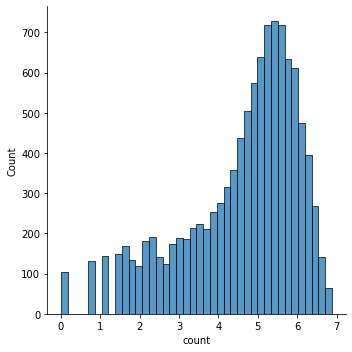

In [128]:
sns.displot(train_data2_y_log)
# applying log transformation has helped the heavy skew of the data however it is still not entirely normal and demonstrates the difficulty of understanding demand

In [129]:
X,y = clean_data(df, cat_cols=['season'], time_cols=[]) # creating dummies of weather vbl cause inflated coefficients suggesting multicollinearity

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, train_data2_y_log, test_size = .3, random_state=2)

In [131]:
y_train

5252   4.263
2090   4.625
4282   5.775
4719   6.184
4817   5.056
        ... 
1099   2.833
2514   5.858
6637   5.861
2575   3.045
7336   4.673
Name: count, Length: 7620, dtype: float64

In [132]:
#Instantiate
lm_model2 = LinearRegression(normalize=True, positive=bool) 
lm_model2.fit(X_train, y_train) 
lm_model2.score(X,y)

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


-1.0601974905118192

In [133]:
X_train.dtypes

holiday                     int64
workingday                  int64
weather                  category
temp                      float64
atemp                     float64
humidity                    int64
windspeed                 float64
temp_buckets             category
tempweather_colddry         int64
tempweather_hotcloudy       int64
tempweather_warmwindy       int64
hour                     category
day                      category
dayofweek                category
month                    category
hour_peak_commute           int64
season_1                     bool
season_2                     bool
season_3                     bool
season_4                     bool
dtype: object

In [134]:
#Predict using your model
y_test_preds2 = lm_model2.predict(X_test)
y_train_preds2 = lm_model2.predict(X_train)

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [135]:
# Mean Squared Logarithmic Error cannot be used when targets contain negative values. - Check for negative predictions
y_test_preds_df2 = pd.DataFrame(data=y_test_preds2, columns=["counts"])
#print(y_test_preds_df.head())
y_test_preds_df2[y_test_preds_df2["counts"]<0]

,counts


In [136]:
# Replace negative predictions with 0 value
y_test_preds2[y_test_preds2 < 0] = 0

In [137]:
#Score using your model
test_score = r2_score(y_test, y_test_preds2)
train_score = r2_score(y_train, y_train_preds2)
test_score, train_score

(0.45287207854853395, 0.43975214933073514)

In [138]:
evaluate_results('LinearRegressionLogged', y_test, y_test_preds2)

LinearRegressionLogged explained_variance:  0.4529
LinearRegressionLogged mean_squared_log_error:  0.0732
LinearRegressionLogged r2:  0.4529
LinearRegressionLogged MAE:  0.8617
LinearRegressionLogged MSE:  1.1956
LinearRegressionLogged RMSE:  1.0934
LinearRegressionLogged RMSLE:  0.2706


In [139]:
# review coefficients 
coeff_df = pd.DataFrame(lm_model2.coef_, X.columns, columns=['Coefficient'])  
coeff_df.sort_values(by="Coefficient", ascending=False)
# we have created a dummy variable out of 'month'... is that helpful?

,Coefficient
season_1,0.583
season_4,0.484
hour_peak_commute,0.419
season_2,0.403
temp_buckets,0.346
holiday,0.258
hour,0.107
dayofweek,0.058
month,0.058
temp,0.038


In [140]:
# transform target and predicted variable back and produce output
lrl_outcome = pd.DataFrame({'Actual': np.exp(y_test), 'Predicted': np.exp(y_test_preds2)}).rename(columns={"Predicted": "LRL_Predicted"})
lrl_outcome.head(10)

,Actual,LRL_Predicted
509,127.000,33.014
1501,73.000,50.095
3754,190.000,69.845
1396,11.000,16.902
9916,310.000,172.917
4298,3.000,51.988
6942,578.000,148.536
7145,14.000,48.074
4745,211.000,195.721
1737,168.000,45.902


Log transformation of the target variable improves model performance reaching R2 score of 0.45 however this is again still very poor. Though the log transformation helped, the desired normal distribution was not met as we see a left skew post transformation. Hence we will move to other methods.

### 3. Random Forest

In [141]:
# create X and y
X, y = clean_data(df, ['season','weather'], ['hour','day','dayofweek','month'])    

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=4)

In [143]:
# Random Forest method - note we have only set season variable with dummies
rfModel = RandomForestRegressor(n_estimators=1000, random_state=4)
rfModel.fit(X_train, y_train)
y_pred_rf = rfModel.predict(X_test)

In [144]:
evaluate_results('RandomForest', y_test, y_pred_rf)

RandomForest explained_variance:  0.8784
RandomForest mean_squared_log_error:  0.1685
RandomForest r2:  0.8784
RandomForest MAE:  42.462
RandomForest MSE:  4076.3328
RandomForest RMSE:  63.8462
RandomForest RMSLE:  0.4104


In [145]:
# review feature importance
feature_names = X_train.columns.values.tolist()
importances = rfModel.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

hour                    0.585
temp                    0.069
atemp                   0.058
humidity                0.056
dayofweek               0.052
workingday              0.039
month                   0.034
day                     0.026
windspeed               0.024
weather_3               0.015
temp_buckets            0.013
season_1                0.012
weather_1               0.003
season_4                0.003
holiday                 0.002
hour_peak_commute       0.002
weather_2               0.002
season_2                0.002
season_3                0.002
tempweather_warmwindy   0.000
tempweather_hotcloudy   0.000
tempweather_colddry     0.000
weather_4               0.000
dtype: float64

In [146]:
std = np.std([tree.feature_importances_ for tree in rfModel.estimators_], axis=0)

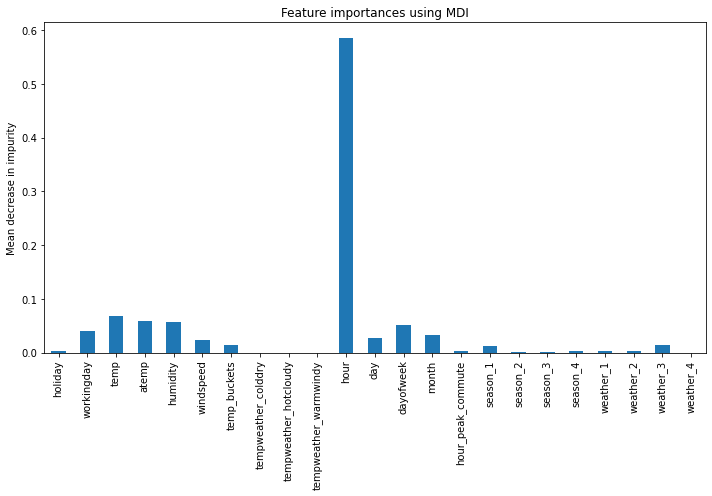

In [147]:
fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(y=np.std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [148]:
# review actual counts against predicted counts
rf_outcome = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf}).rename(columns={"Predicted": "RF_Predicted"})
rf_outcome.head(10)

,Actual,RF_Predicted
3039,247,286.088
7091,286,218.335
10193,20,29.744
8986,677,470.138
5856,19,7.536
6056,108,114.593
4882,54,110.333
8348,28,30.907
500,38,25.753
9878,81,90.268


This model appears to perform extremely well, strongly suggesting there is overfitting. We also see one variable having an extortionately large importance, which dampens imfluence of other variables. This is because Random forest favours variables with more levels, of which 'hour' variable has 24. Try without this variable, or bucket
it.

In [149]:
# drop hour variable for testing
df2 = df.drop(['hour'], axis=1)

In [150]:
#Use the function to create X and y
X, y = clean_data(df2, cat_cols=['season','weather'], time_cols=['day','dayofweek','month'])  

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=5)

In [152]:
# Random Forest method - note we have only set season variable with dummies
rfModel2 = RandomForestRegressor(n_estimators=1000, random_state=5)
rfModel2.fit(X_train, y_train)
y_pred_rf2 = rfModel2.predict(X_test)

In [153]:
evaluate_results('RandomForest2', y_test, y_pred_rf2)

RandomForest2 explained_variance:  0.4216
RandomForest2 mean_squared_log_error:  1.3259
RandomForest2 r2:  0.42
RandomForest2 MAE:  95.9683
RandomForest2 MSE:  18716.0838
RandomForest2 RMSE:  136.8067
RandomForest2 RMSLE:  1.1515


In [154]:
# review feature importance
feature_names = X_train.columns.values.tolist()
importances = rfModel2.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

atemp                   0.206
humidity                0.204
windspeed               0.126
day                     0.117
temp                    0.104
month                   0.080
dayofweek               0.068
workingday              0.018
weather_2               0.014
weather_1               0.012
hour_peak_commute       0.009
temp_buckets            0.008
weather_3               0.007
season_2                0.007
season_3                0.006
season_4                0.006
season_1                0.005
holiday                 0.003
weather_4               0.000
tempweather_warmwindy   0.000
tempweather_hotcloudy   0.000
tempweather_colddry     0.000
dtype: float64

In [155]:
std = np.std([tree.feature_importances_ for tree in rfModel2.estimators_], axis=0)

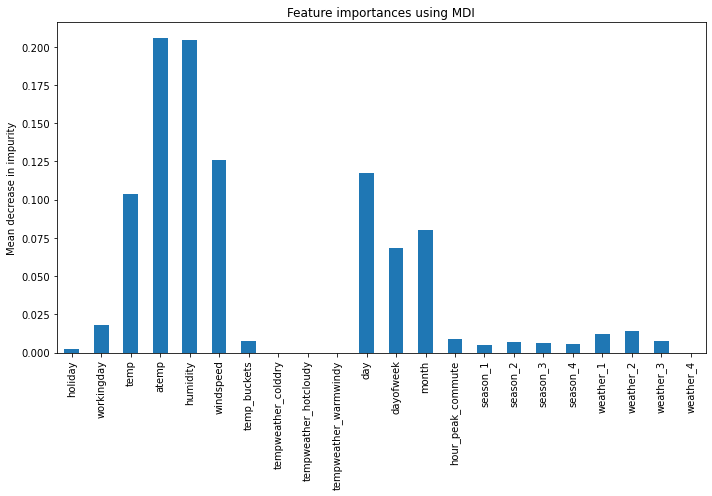

In [156]:
fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(y=np.std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Again we see the influence of large variety in a variable impacting feature importance. In this case, numerical features are being emphasised over boolean and/or categorical variables. Of course as hour is a strong feature we will need to include, but it was interesting to see how other features behave without it's presence. Will bucket the variables to try to counteract the impact features with many levels having inflated impact.

#### 4b. Random Forest with bucketed variables

In [157]:
# Bucket numerical variables with many levels 
df_bucketed = df
df_bucketed['hour'] = df_bucketed['hour'].astype('int64')

# hour
timeofday_conditions = [
    (df_bucketed['hour'] >= 0) & (df_bucketed['hour'] < 6),
    (df_bucketed['hour'] >= 6) & (df_bucketed['hour'] < 12),
    (df_bucketed['hour'] >= 12) & (df_bucketed['hour'] < 17),
    (df_bucketed['hour'] >= 17) & (df_bucketed['hour'] < 20),
    (df_bucketed['hour'] >= 20) 
]
timeofday_choices = [0,1,2,3,4]  # early morning, morning, afternoon, evening, night
df_bucketed['hour_buckets'] = np.select(timeofday_conditions, timeofday_choices, default=999)

# atemp
atemp_conditions = [
    (df_bucketed['atemp'] >= 0) & (df_bucketed['atemp'] < 10),
    (df_bucketed['atemp'] >= 10) & (df_bucketed['atemp'] < 20),
    (df_bucketed['atemp'] >= 20) & (df_bucketed['atemp'] < 30),
    (df_bucketed['atemp'] > 30)
]
atemp_choices = [0,1,2,3] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
df_bucketed['atemp_buckets'] = np.select(atemp_conditions, atemp_choices, default=999)

# humidity
humidity_conditions = [
    (df_bucketed['humidity'] >= 0) & (df_bucketed['humidity'] < 20),
    (df_bucketed['humidity'] >= 20) & (df_bucketed['humidity'] < 40),
    (df_bucketed['humidity'] >= 40) & (df_bucketed['humidity'] < 60),
    (df_bucketed['humidity'] >= 60) & (df_bucketed['humidity'] < 80),
    (df_bucketed['humidity'] > 80)
]
humidity_choices = [0,1,2,3,4] 
df_bucketed['humidity_buckets'] = np.select(humidity_conditions, humidity_choices, default=999)

# windspeed
windspeed_conditions = [
    (df_bucketed['windspeed'] >= 0) & (df_bucketed['windspeed'] < 5),
    (df_bucketed['windspeed'] >= 5) & (df_bucketed['windspeed'] < 10),
    (df_bucketed['windspeed'] >= 10) & (df_bucketed['windspeed'] < 15),
    (df_bucketed['windspeed'] >= 15) & (df_bucketed['windspeed'] < 20),
    (df_bucketed['windspeed'] >= 20) & (df_bucketed['windspeed'] < 30),
    (df_bucketed['windspeed'] > 30)
]
windspeed_choices = [0,1,2,3,4,5] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
df_bucketed['windspeed_buckets'] = np.select(windspeed_conditions, windspeed_choices, default=999)

#df_bucketed.groupby("windspeed_buckets")['count'].sum().plot.bar(rot=0)

df_bucketed2 = df_bucketed.drop(['hour','temp', 'atemp','humidity','windspeed'], axis=1)

<AxesSubplot:xlabel='hour_buckets'>

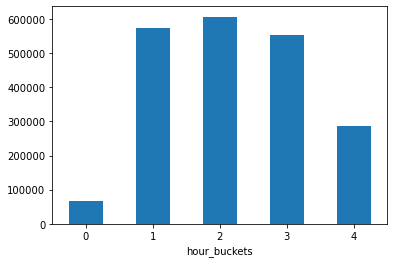

In [158]:
df_bucketed.groupby("hour_buckets")['count'].sum().plot.bar(rot=0)

In [159]:
#sns.displot(df['windspeed']) # view distributions of int variables for bucketing

In [160]:
df_bucketed2.head()

,datetime,season,holiday,workingday,weather,casual,registered,count,temp_buckets,tempweather_colddry,tempweather_hotcloudy,tempweather_warmwindy,day,dayofweek,month,hour_peak_commute,hour_buckets,atemp_buckets,humidity_buckets,windspeed_buckets
0,2011-01-01 00:00:00,1,0,0,1,3,13,16,0,1,1,1,1,5,1,0,0,1,4,0
1,2011-01-01 01:00:00,1,0,0,1,8,32,40,0,1,1,1,1,5,1,0,0,1,999,0
2,2011-01-01 02:00:00,1,0,0,1,5,27,32,0,1,1,1,1,5,1,0,0,1,999,0
3,2011-01-01 03:00:00,1,0,0,1,3,10,13,0,1,1,1,1,5,1,0,0,1,3,0
4,2011-01-01 04:00:00,1,0,0,1,0,1,1,0,1,1,1,1,5,1,0,0,1,3,0


In [161]:
#Use the function to create X and y
X, y = clean_data(df_bucketed2, cat_cols=[], time_cols=['day','dayofweek','month'])  

In [162]:
X_train.dtypes

holiday                     int64
workingday                  int64
temp                      float64
atemp                     float64
humidity                    int64
windspeed                 float64
temp_buckets             category
tempweather_colddry         int64
tempweather_hotcloudy       int64
tempweather_warmwindy       int64
day                      category
dayofweek                category
month                    category
hour_peak_commute           int64
season_1                     bool
season_2                     bool
season_3                     bool
season_4                     bool
weather_1                    bool
weather_2                    bool
weather_3                    bool
weather_4                    bool
dtype: object

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=6)

In [164]:
# Random Forest method - note we have only set season variable with dummies
rfModel3 = RandomForestRegressor(n_estimators=1000, random_state=6)
rfModel3.fit(X_train, y_train)
y_pred_rf3 = rfModel3.predict(X_test)

In [165]:
evaluate_results('RandomForest3', y_test, y_pred_rf3)

RandomForest3 explained_variance:  0.7145
RandomForest3 mean_squared_log_error:  0.4847
RandomForest3 r2:  0.7145
RandomForest3 MAE:  64.0106
RandomForest3 MSE:  9544.7514
RandomForest3 RMSE:  97.6972
RandomForest3 RMSLE:  0.6962


In [166]:
# review feature importance
feature_names = X_train.columns.values.tolist()
importances = rfModel3.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

hour_buckets            0.468
atemp_buckets           0.095
day                     0.079
dayofweek               0.064
month                   0.057
windspeed_buckets       0.052
humidity_buckets        0.051
temp_buckets            0.042
weather                 0.031
workingday              0.029
season                  0.023
hour_peak_commute       0.007
holiday                 0.002
tempweather_colddry     0.000
tempweather_hotcloudy   0.000
tempweather_warmwindy   0.000
dtype: float64

In [167]:
std = np.std([tree.feature_importances_ for tree in rfModel3.estimators_], axis=0)

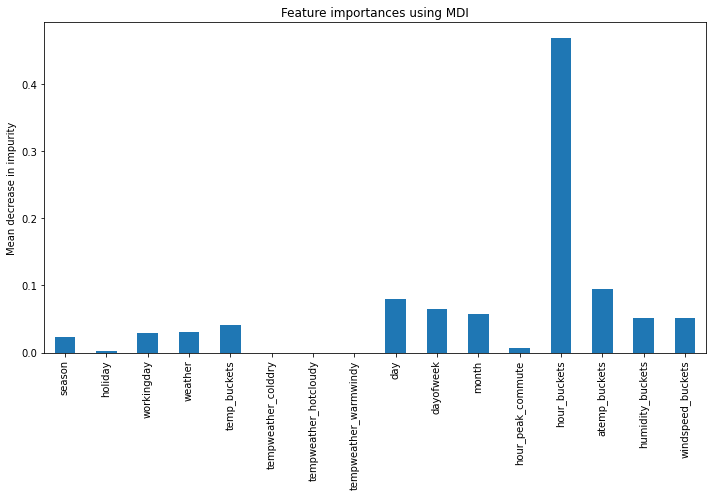

In [168]:
fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(y=np.std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Okay, now that the levels are more even across variables we see that hour justifiably is a strong predictor.

#### 4c. Random forest with bucketed variables and log transformed target variable

In [169]:
# Use the function to create X and y
X, y = clean_data(df_bucketed2, cat_cols=['season','weather','hour_buckets'], time_cols=['day','dayofweek','month'])  

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, train_data2_y_log, test_size = .3, random_state=7)

In [171]:
# Random Forest method - note we have only set season variable with dummies
rfModel4 = RandomForestRegressor(n_estimators=1000, random_state=7)
rfModel4.fit(X_train, y_train)
y_pred_rf4 = rfModel4.predict(X_test)

In [172]:
evaluate_results('RandomForest3', y_test, y_pred_rf4)

RandomForest3 explained_variance:  0.7422
RandomForest3 mean_squared_log_error:  0.0464
RandomForest3 r2:  0.742
RandomForest3 MAE:  0.5377
RandomForest3 MSE:  0.5598
RandomForest3 RMSE:  0.7482
RandomForest3 RMSLE:  0.2155


In [173]:
# review feature importance
feature_names = X_train.columns.values.tolist()
importances = rfModel4.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(ascending=False)

hour_buckets_0          0.599
temp_buckets            0.055
day                     0.049
month                   0.042
windspeed_buckets       0.041
dayofweek               0.041
humidity_buckets        0.035
hour_buckets_3          0.024
workingday              0.021
atemp_buckets           0.020
weather_3               0.011
hour_buckets_2          0.011
hour_buckets_4          0.008
hour_buckets_1          0.007
hour_peak_commute       0.007
weather_1               0.006
weather_2               0.006
season_1                0.006
season_4                0.004
season_3                0.003
season_2                0.003
holiday                 0.001
weather_4               0.000
tempweather_warmwindy   0.000
tempweather_hotcloudy   0.000
tempweather_colddry     0.000
dtype: float64

In [174]:
std = np.std([tree.feature_importances_ for tree in rfModel4.estimators_], axis=0)

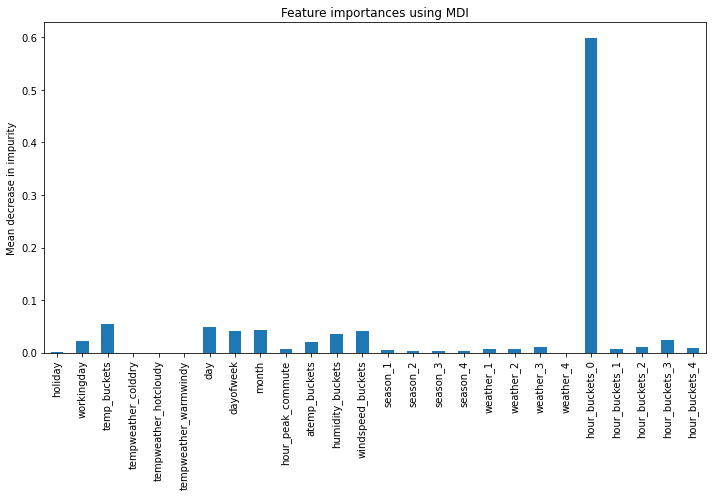

In [175]:
fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(y=np.std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [176]:
rf_outcome = pd.DataFrame({'Actual': np.exp(y_test), 'Predicted': np.exp(y_pred_rf4)}).rename(columns={"Predicted": "RF_Predicted"})
rf_outcome.head(10)

,Actual,RF_Predicted
3502,285.000,146.624
6462,138.000,137.291
3275,215.000,253.017
3503,184.000,130.642
6813,24.000,5.227
2400,153.000,147.512
3057,52.000,47.212
247,76.000,42.071
5174,250.000,201.474
9899,432.000,179.005


### Fit the model to unseen test data for validation 

### Attempt 1 - Linear Regression with log transformed target

In [179]:
# adjustments needed as test data is different (no count, registered columns)
# note there are no missing values in this data
# in case there are nulls in your data, numerical values can be imputed by uncommenting, cases with categorical missing values should be dropped as imputing does not make sense in this context
def clean_data2(df, cat_cols, time_cols):
    
    '''
    Function to clean data, replace nulls, add dummies for categorical variables and set data types
    This differs from clean_data function as there is no split of train/test data and no target included in test data
    Input: df - dataframe; cat_cols - categorical feature column names; time_cols - feature columns regarding date/datetime
    Output: X - dataset of transformed features; y - dataset containing target only
    '''
    
    ## there are no null values in this dataset, uncomment below code if dataset analysed contains nulls in numerical to replace these with mean and utilise these cases
    #num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    #for col in num_cols:
    #    df[col].fillna((df[col].mean()), inplace=True)
    
    cat_cols = cat_cols 
    #df = df.dropna(axis=0, subset=cat_cols) #drop rows with missing vals
    for col in cat_cols:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', dtype='bool')],  axis=1)
    
    time_cols = time_cols
    #df = df.dropna(axis=0, subset=time_cols) #drop rows with missing vals
    df[time_cols] = df[time_cols].astype('category')
    
    X = df
    
    return X

In [180]:
# prepare test data to match LR data, drop bucketed values which were added for RF methods
X = clean_data2(test_data2, cat_cols=['season'], time_cols=['hour'])

In [181]:
lr_test_datetime = X["datetime"]
lr_test_features = X.drop(["datetime"], axis=1)

In [182]:
lr_test_predictions = lm_model2.predict(lr_test_features)

/Users/karina.gorasia/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [183]:
# quick glance at test predictions stats
pd.DataFrame(np.exp(lr_test_predictions)).describe()

,0
count,6493.000
mean,156.980
std,138.937
min,5.780
25%,47.142
50%,106.239
75%,235.083
max,789.349


In [184]:
# quick compare with train data stats
pd.DataFrame(train_data['count']).describe()

,count
count,10886.000
mean,191.574
std,181.144
min,1.000
25%,42.000
50%,145.000
75%,284.000
max,977.000


In [185]:
# combine datetime and forecasted counts
lr_test_outcome = pd.DataFrame({'datetime': lr_test_datetime, 'count': np.exp(lr_test_predictions)})
lr_test_outcome

,datetime,count
0,2011-01-20 00:00:00,15.236
1,2011-01-20 01:00:00,13.549
2,2011-01-20 02:00:00,15.078
3,2011-01-20 03:00:00,18.465
4,2011-01-20 04:00:00,20.549
...,...,...
6488,2012-12-31 19:00:00,168.204
6489,2012-12-31 20:00:00,187.184
6490,2012-12-31 21:00:00,208.306
6491,2012-12-31 22:00:00,228.392


In [186]:
# export file for external (Kaggle) validation
lr_test_outcome.to_csv('lr_bike_sharing_demand.csv', index=False)

Score on Kaggle: 1.08928 (RMSLE)

### Attempt 2 - Random Forest with bucketed variables, dummies, and log transformed target

we will follow the bucketed data with log transformed variable, as though it had a large importance for hour, this was not unusual across the models, and the model performed well.

In [187]:
# ensure the data has the correct features
test_data3 = test_data2

In [188]:
test_data3['hour'] = test_data3['hour'].astype('int64')

# hour
timeofday_conditions = [
    (test_data3['hour'] >= 0) & (test_data3['hour'] < 6),
    (test_data3['hour'] >= 6) & (test_data3['hour'] < 12),
    (test_data3['hour'] >= 12) & (test_data3['hour'] < 17),
    (test_data3['hour'] >= 17) & (test_data3['hour'] < 20),
    (test_data3['hour'] >= 20) 
]
timeofday_choices = [0,1,2,3,4]  # early morning, morning, afternoon, evening, night
test_data3['hour_buckets'] = np.select(timeofday_conditions, timeofday_choices, default=999)

# atemp
atemp_conditions = [
    (test_data3['atemp'] >= 0) & (test_data3['atemp'] < 10),
    (test_data3['atemp'] >= 10) & (test_data3['atemp'] < 20),
    (test_data3['atemp'] >= 20) & (test_data3['atemp'] < 30),
    (test_data3['atemp'] > 30)
]
atemp_choices = [0,1,2,3] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
test_data3['atemp_buckets'] = np.select(atemp_conditions, atemp_choices, default=999)

# humidity
humidity_conditions = [
    (test_data3['humidity'] >= 0) & (test_data3['humidity'] < 20),
    (test_data3['humidity'] >= 20) & (test_data3['humidity'] < 40),
    (test_data3['humidity'] >= 40) & (test_data3['humidity'] < 60),
    (test_data3['humidity'] >= 60) & (test_data3['humidity'] < 80),
    (test_data3['humidity'] > 80)
]
humidity_choices = [0,1,2,3,4] 
test_data3['humidity_buckets'] = np.select(humidity_conditions, humidity_choices, default=999)

# windspeed
windspeed_conditions = [
    (test_data3['windspeed'] >= 0) & (test_data3['windspeed'] < 5),
    (test_data3['windspeed'] >= 5) & (test_data3['windspeed'] < 10),
    (test_data3['windspeed'] >= 10) & (test_data3['windspeed'] < 15),
    (test_data3['windspeed'] >= 15) & (test_data3['windspeed'] < 20),
    (test_data3['windspeed'] >= 20) & (test_data3['windspeed'] < 30),
    (test_data3['windspeed'] > 30)
]
windspeed_choices = [0,1,2,3,4,5] # 0 = cold, 1 = mild, 2 = warm, 3 = hot
test_data3['windspeed_buckets'] = np.select(windspeed_conditions, windspeed_choices, default=999)

#df_bucketed.groupby("windspeed_buckets")['count'].sum().plot.bar(rot=0)

test_data3 = test_data3.drop(['hour','temp', 'atemp','humidity','windspeed'], axis=1)

In [189]:
test_data3.dtypes

datetime                 datetime64[ns]
season                         category
holiday                           int64
workingday                        int64
weather                        category
temp_buckets                   category
tempweather_colddry               int64
tempweather_hotcloudy             int64
tempweather_warmwindy             int64
day                            category
dayofweek                      category
month                          category
hour_peak_commute                 int64
hour_buckets                      int64
atemp_buckets                     int64
humidity_buckets                  int64
windspeed_buckets                 int64
dtype: object

In [190]:
test_data3_datetime = test_data3['datetime']
test_data3_features = test_data3.drop(columns = ['datetime'], axis=1)

In [191]:
X = clean_data2(test_data3_features, cat_cols=['season','weather','hour_buckets'], time_cols=['day','dayofweek','month'])    

In [192]:
X.dtypes

holiday                     int64
workingday                  int64
temp_buckets             category
tempweather_colddry         int64
tempweather_hotcloudy       int64
tempweather_warmwindy       int64
day                      category
dayofweek                category
month                    category
hour_peak_commute           int64
atemp_buckets               int64
humidity_buckets            int64
windspeed_buckets           int64
season_1                     bool
season_2                     bool
season_3                     bool
season_4                     bool
weather_1                    bool
weather_2                    bool
weather_3                    bool
weather_4                    bool
hour_buckets_0               bool
hour_buckets_1               bool
hour_buckets_2               bool
hour_buckets_3               bool
hour_buckets_4               bool
dtype: object

In [193]:
# Random Forest method - note we have only set season variable with dummies
rf1_test_predictions = rfModel4.predict(X)

In [194]:
# quick glance at test predictions stats
pd.DataFrame(np.exp(rf1_test_predictions)).describe()

,0
count,6493.000
mean,166.872
std,148.752
min,2.043
25%,34.103
50%,139.486
75%,243.355
max,742.244


In [195]:
# quick compare with train data stats
pd.DataFrame(train_data['count']).describe()

,count
count,10886.000
mean,191.574
std,181.144
min,1.000
25%,42.000
50%,145.000
75%,284.000
max,977.000


In [196]:
# combine datetime and forecasted counts
rf1_test_outcome = pd.DataFrame({'datetime': test_data3_datetime, 'count': np.exp(rf1_test_predictions)})
rf1_test_outcome

,datetime,count
0,2011-01-20 00:00:00,7.156
1,2011-01-20 01:00:00,6.730
2,2011-01-20 02:00:00,6.730
3,2011-01-20 03:00:00,4.700
4,2011-01-20 04:00:00,4.700
...,...,...
6488,2012-12-31 19:00:00,287.562
6489,2012-12-31 20:00:00,88.466
6490,2012-12-31 21:00:00,73.748
6491,2012-12-31 22:00:00,84.770


In [197]:
# export file for external (Kaggle) validation
rf1_test_outcome.to_csv('rf1_bike_sharing_demand.csv', index=False)

#### Score on Kaggle: 0.73501 (RMSLE)

### Attempt 3 - Random Forest with bucketed variables, no dummies  and no log transformed target

In [198]:
#Use the function to create X and y
X = clean_data2(test_data3_features, cat_cols=[], time_cols=['day','dayofweek','month']) 

In [199]:
X.dtypes

season                   category
holiday                     int64
workingday                  int64
weather                  category
temp_buckets             category
tempweather_colddry         int64
tempweather_hotcloudy       int64
tempweather_warmwindy       int64
day                      category
dayofweek                category
month                    category
hour_peak_commute           int64
hour_buckets                int64
atemp_buckets               int64
humidity_buckets            int64
windspeed_buckets           int64
dtype: object

In [200]:
# Random Forest method - note we have only set season variable with dummies
rf2_test_predictions = rfModel3.predict(X)

In [201]:
# quick glance at test predictions stats
pd.DataFrame(rf2_test_predictions).describe()

,0
count,6493.000
mean,200.603
std,155.255
min,5.538
25%,64.470
50%,182.728
75%,295.919
max,793.624


In [202]:
# quick compare with train data stats
pd.DataFrame(train_data['count']).describe()

,count
count,10886.000
mean,191.574
std,181.144
min,1.000
25%,42.000
50%,145.000
75%,284.000
max,977.000


In [203]:
# combine datetime and forecasted counts
rf2_test_outcome = pd.DataFrame({'datetime': test_data3_datetime, 'count': rf2_test_predictions})
rf2_test_outcome

,datetime,count
0,2011-01-20 00:00:00,14.299
1,2011-01-20 01:00:00,12.322
2,2011-01-20 02:00:00,12.322
3,2011-01-20 03:00:00,12.487
4,2011-01-20 04:00:00,12.487
...,...,...
6488,2012-12-31 19:00:00,270.093
6489,2012-12-31 20:00:00,96.150
6490,2012-12-31 21:00:00,82.699
6491,2012-12-31 22:00:00,85.621


In [204]:
# export file for external (Kaggle) validation
rf2_test_outcome.to_csv('rf2_bike_sharing_demand.csv', index=False)

#### Score on Kaggle: 0.80740 (RMSLE)

As expected, the log transformed target model performed better, though with a largely different RMSLE score to that from training, suggesting that our models were overfitting.

In [210]:
# Bring all the model performances into one view
model_performance = pd.DataFrame({'Model': ["Linear Regression, log transformed target",
                                            "Random Forest with bucketed variables, no dummies, no log transformed target",
                                            "Random Forest with bucketed variables, dummies and log transformed target"], 
                                  'Training RMSLE': [0.2706,0.6962,0.2155],
                                  'Validation RMSLE': [1.08928,0.8074,0.73501]})
model_performance.style.set_properties(subset=['Model'], **{'width': '300px'})

,Model,Training RMSLE,Validation RMSLE
0,"Linear Regression, log transformed target",0.270600,1.089280
1,"Random Forest with bucketed variables, no dummies, no log transformed target",0.696200,0.807400
2,"Random Forest with bucketed variables, dummies and log transformed target",0.215500,0.735010


## Evaluate the Results

### Let's cycle back to our three key questions:

1. Does weather impact bike hire? 
<br>Yes. More settled conditions and warmer temperatures drive higher demand, though there are other less expected conditions to consider when forecasting bike sharing demand too, such as cooler settled weather or windier conditions when its warm.
<br> 
2. Is demand the same regardless of what day of the week it is? Is bike sharing demand consistent?
<br>When analysing trends across days alone, there was no significant difference in average bike sharing demand.
When looking across months, the winter months were unsurprisingly quieter. 
However when we separate weekends from weekdays, we see that peak commuting hours signal higher bike demand on weekdays, whereas weekend hire follows a more normal distribution. This is a useful factor to consider.
<br>We also discovered that the distribution of bikes hired has a very positive skew, i.e. there are many more records showing lower levels of bike demand. This poses an issue because model performance, particularly in regression models, is negatively impacted by skewed data. Hence it would be in our favour to log transform the target variable, though note that after transformation, there is still a skew in the data, demonstrating that demand is not consistent and not the easiest to predict!
<br> 
3. How well can we predict bike share demand? 
<br>It's clear that modelling bike sharing demand is no easy feat. Though we did find some factors repeatedly useful in helping understand and predict demand (temperatures, time of day), in spite of trying different modelling methods and approaches such as scaling, dummying difference variables and log transformation, it stills proves a challenge to accurately predict bike sharing demand. We also see that performance in validation drops greatly, signalling there is some clear overfitting happening during training. Linear Regression is arguably not the way forwads for this problem, though we have demonstrated that considering many features at different levels of granularity (datetime) and exploring different models, we can work towards understanding bike sharing demand more.


### 4. Decision Tree model

In [ ]:
#regr_1 = DecisionTreeRegressor(max_depth=2)
#regr_2 = DecisionTreeRegressor(max_depth=5)
#regr_1.fit(X, y)
#regr_2.fit(X, y)
#
## Predict
#y_1 = regr_1.predict(X_test)
#y_2 = regr_2.predict(X_test)

In [ ]:
#evaluate_results('DecisionTree', y_test, y_1)

In [ ]:
#evaluate_results('DecisionTree', y_test, y_2)

In [ ]:
#dt_outcome = pd.DataFrame({'Actual': y_test, 'Predicted': y_2}).rename(columns={"Predicted": "DT_Predicted"})
#dt_outcome.head(10)

In [ ]:
# merge the dfs to create plots, join datetime
#combined_results = pd.concat([lr_outcome, rf_outcome, dt_outcome], join="inner", axis=1)
#combined_results = combined_results.loc[:,~combined_results.columns.duplicated()]
#combined_results

In [ ]:
#plt.plot(combined_results['LR_Predicted'], combined_results['Actual'], label = "LR")
#plt.plot(combined_results['RF_Predicted'], combined_results['Actual'], label = "RF")
#plt.plot(combined_results['DT_Predicted'], combined_results['Actual'], label = "DT")
#plt.legend()
#plt.show()